In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import distributions
import matplotlib.pyplot as plt

from bbb.utils.pytorch_setup import DEVICE
from bbb.config.parameters import PriorParameters

## Single Gaussian

In [24]:
prior_params_g = PriorParameters(
    w_sigma=1.,
    b_sigma=1.,
    w_sigma_2=0.2,
    b_sigma_2=0.2,
    w_mixture_weight=0.5,
    b_mixture_weight=0.5,
)

In [25]:
w_prior_g = distributions.Normal(0, prior_params_g.w_sigma)
b_prior_g = distributions.Normal(0, prior_params_g.b_sigma)

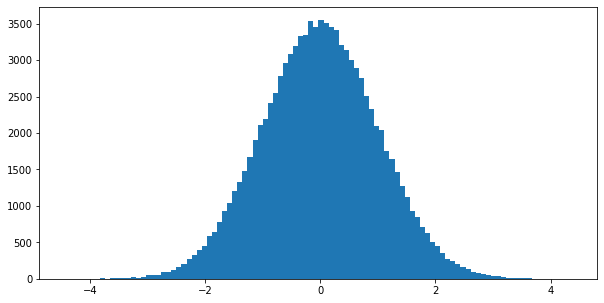

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w_prior_mog_samples =w_prior_g.sample(sample_shape=(100000,))
ax.hist(w_prior_mog_samples.cpu().numpy(), bins=100)
pass

In [27]:
torch.diff(w_prior_g.cdf(torch.tensor([-0.3, 0.3], device=DEVICE)))

tensor([0.2358], device='cuda:1')

In [28]:
torch.diff(w_prior_g.cdf(torch.tensor([-0.4, 0.4], device=DEVICE)))

tensor([0.3108], device='cuda:1')

In [29]:
torch.diff(w_prior_g.cdf(torch.tensor([-0.5, 0.5], device=DEVICE)))

tensor([0.3829], device='cuda:1')

## MoG

In [5]:
prior_params_mog = PriorParameters(
    w_sigma=np.exp(-1),
    b_sigma=np.exp(-1),
    w_sigma_2=np.exp(-7),
    b_sigma_2=np.exp(-7),
    w_mixture_weight=0.5,
    b_mixture_weight=0.5,
)

In [6]:
w_mix = distributions.Categorical(torch.tensor((prior_params_mog.w_mixture_weight, 1-prior_params_mog.w_mixture_weight), device=DEVICE))
b_mix = distributions.Categorical(torch.tensor((prior_params_mog.b_mixture_weight, 1-prior_params_mog.b_mixture_weight), device=DEVICE))

# Specify the individual components - whilst these appear to be multivariate Gaussians they will be seperated
w_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
b_norm_comps = distributions.Normal(torch.zeros(2, device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

# Easier version to play around with
# w_norm_comps = distributions.Normal(torch.tensor([-1.,1.], device=DEVICE), torch.tensor((prior_params_mog.w_sigma, prior_params_mog.w_sigma_2), device=DEVICE, dtype=torch.float32))
# b_norm_comps = distributions.Normal(torch.tensor([0.,0.], device=DEVICE), torch.tensor((prior_params_mog.b_sigma, prior_params_mog.b_sigma_2), device=DEVICE, dtype=torch.float32))

# Create the GMMs
w_prior_mog = distributions.MixtureSameFamily(w_mix, w_norm_comps)
b_prior_mog = distributions.MixtureSameFamily(b_mix, b_norm_comps)

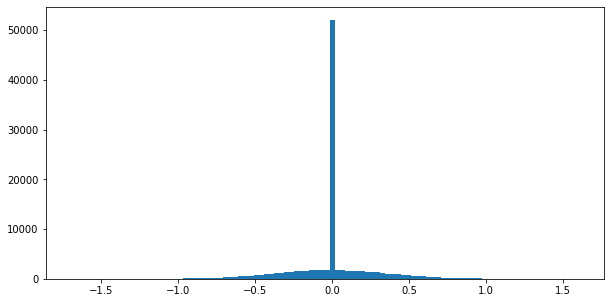

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w_prior_mog_samples =w_prior_mog.sample(sample_shape=(100000,))
ax.hist(w_prior_mog_samples.cpu().numpy(), bins=100)
pass

In [18]:
torch.diff(w_prior_mog.cdf(torch.tensor([-0.3, 0.3], device=DEVICE)))

tensor([0.7926], device='cuda:1')

In [11]:
torch.diff(w_prior_mog.cdf(torch.tensor([-0.4, 0.4], device=DEVICE)))

tensor([0.8616], device='cuda:1')

In [36]:
torch.diff(w_prior.cdf(torch.tensor([-0.5, 0.5], device=DEVICE)))

tensor([0.9129], device='cuda:1')

In [12]:
w_prior_mog.cdf(torch.tensor([-4], device=DEVICE)), w_prior_mog.cdf(torch.tensor([2], device=DEVICE))

(tensor([0.], device='cuda:1'), tensor([1.], device='cuda:1'))

## Laplacian

In [13]:
# w_prior_l = distributions.Laplace(0, prior_params.w_sigma)
# b_prior_l = distributions.Laplace(0, prior_params.b_sigma)

w_prior_l = distributions.Laplace(0, 0.1)
b_prior_l = distributions.Laplace(0, 0.1)

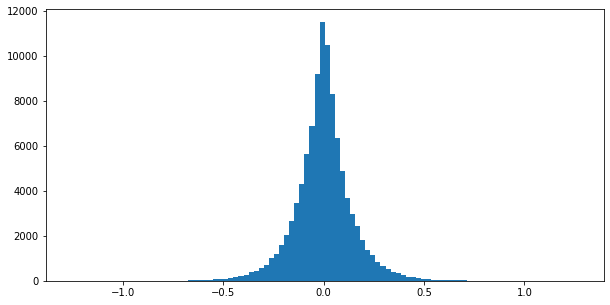

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w_prior_l_samples =w_prior_l.sample(sample_shape=(100000,))
ax.hist(w_prior_l_samples.cpu().numpy(), bins=100)
pass